In [1]:
import sys
import os
import torch

import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, os.path.abspath('..'))
from src.models.pytorch_ssim.ssim import SSIM


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = torch.load('1sample.data')
sample = {k: v[0].to(device) for k, v in data['sample'].items()}
attn = data['attn'][0].to(device)
feat = data['feat'][0].to(device)
ssim_criterion = SSIM(window_size=3, channel=32)

# Random input with SGD

Text(0, 0.5, 'reconstruction')

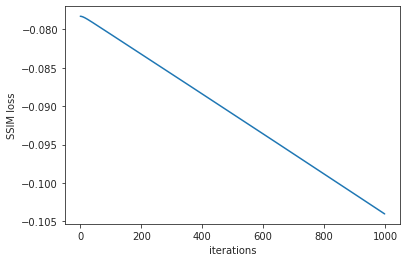

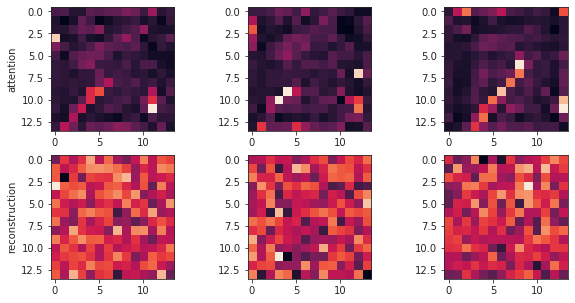

In [2]:
rand_data = torch.rand(attn.shape).to(device)
rand_data = torch.autograd.Variable(rand_data, requires_grad=True)

optimizer = torch.optim.SGD([rand_data], lr=0.01, momentum=0.9, weight_decay=1.e-4)
loss_log = []
for i in range(1000):
    optimizer.zero_grad()
    ssim_loss = -ssim_criterion(rand_data[:-1], attn[1:])
    loss_log.append(ssim_loss.item())
    ssim_loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(loss_log)
plt.ylabel('SSIM loss')
plt.xlabel('iterations')
        
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for t in range(3):
    axes[0, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy())
    axes[1, t].imshow(rand_data[t].mean(dim=0).cpu().detach().numpy())
axes[0, 0].set_ylabel('attention')
axes[1, 0].set_ylabel('reconstruction')

# Random input with Adam

Text(0, 0.5, 'reconstruction')

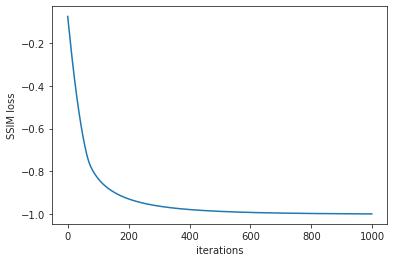

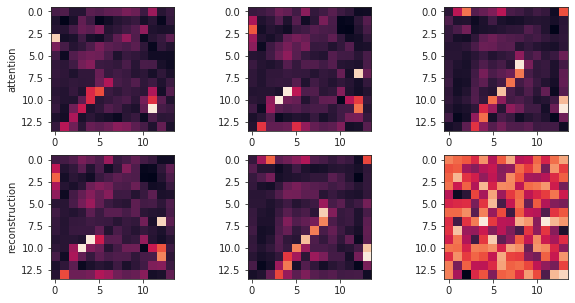

In [3]:
rand_data = torch.rand(attn.shape).to(device)
rand_data = torch.autograd.Variable(rand_data, requires_grad=True)

optimizer = torch.optim.Adam([rand_data], lr=0.01)
loss_log = []
for i in range(1000):
    optimizer.zero_grad()
    ssim_loss = -ssim_criterion(rand_data[:-1], attn[1:])
    loss_log.append(ssim_loss.item())
    ssim_loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(loss_log)
plt.ylabel('SSIM loss')
plt.xlabel('iterations')

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for t in range(3):
    axes[0, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy())
    axes[1, t].imshow(rand_data[t].mean(dim=0).cpu().detach().numpy())
axes[0, 0].set_ylabel('attention')
axes[1, 0].set_ylabel('reconstruction')

# Experiment with conv decoder for hallucination

In [4]:
from torch.nn.init import normal_, constant_

class HalluModel(torch.nn.Module):
    def __init__(self):
        super(HalluModel, self).__init__()
        _std = 0.001
        self.fc_hallu = torch.nn.Linear(512, 64*7*7)
        normal_(self.fc_hallu.weight, 0, _std)
        constant_(self.fc_hallu.bias, 0)

        self.conv1 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(32)
        
        self.relu = torch.nn.ReLU()

        
    def forward(self, x):
        x = self.relu(self.fc_hallu(x))         # (?, 64x7x7)
        x = x.reshape(-1, 64, 7, 7)             # (?, 64, 7, 7)

        x = self.relu(self.bn1(self.conv1(x)))  # (?, 64, 7, 7)
        x = self.upsample(x)  # (?, 64, 14, 14)
        x = self.relu(self.bn2(self.conv2(x)))  # (?, 32, 14, 14)
        x = self.relu(self.bn3(self.conv3(x)))  # (?, 32, 14, 14)
        return x

Text(0, 0.5, 'hallucination')

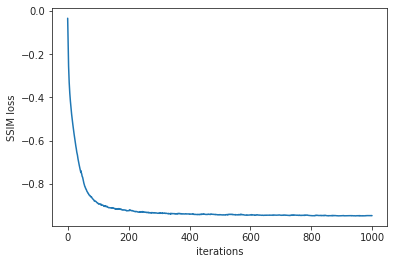

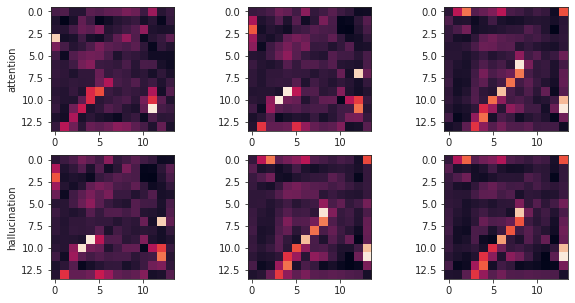

In [5]:
model = HalluModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_log = []
for i in range(1000):
    hallu = model(feat)
    
    optimizer.zero_grad()
    ssim_loss = -ssim_criterion(hallu[:-1], attn[1:])
    loss_log.append(ssim_loss.item())
    ssim_loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(loss_log)
plt.ylabel('SSIM loss')
plt.xlabel('iterations')

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for t in range(3):
    axes[0, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy())
    axes[1, t].imshow(hallu[t].mean(dim=0).cpu().detach().numpy())
axes[0, 0].set_ylabel('attention')
axes[1, 0].set_ylabel('hallucination')